# Predicting Player Goal Counts for the Maple Leafs
___

In [3]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import svm, preprocessing, pipeline, set_config, compose, model_selection

### Data Preparation
___

In [42]:
# create connection to database
connection = psycopg2.connect(
    host="localhost",
    database="50_in_07",
    user="tanyatang")

In [43]:
# select relevant data from database
cursor = connection.cursor()
cursor.execute(
    """
    WITH data AS (SELECT players.first_name
                       , players.last_name
                       , CONCAT(players.first_name, ' ', players.last_name) as full_name
                       , players.current_age
                       , players.height
                       , players.weight
                       , players.primary_position
                       , teams0.name AS opposing_team
                       , teams2.name AS away_team
                       , teams1.name AS home_team
                       , games.game_type
                       , game_players.time_on_ice
                       , game_players.assists
                       , game_players.goals
                       , game_players.shots
                       , game_players.hits
                       , game_players.penalty_minutes
                       , game_players.takeaways
                       , game_players.giveaways
                       , game_players.blocked
                       , game_players.plus_minus
                    FROM games
                    JOIN teams AS teams0
                      ON (games.home_team_id + games.away_team_id - 10) = teams0.id
                    JOIN teams AS teams1
                      ON games.home_team_id = teams1.id
                    JOIN teams AS teams2
                      ON games.away_team_id = teams2.id
                    JOIN game_players
                      ON games.id = game_players.game_id
                    JOIN players
                      ON game_players.player_id = players.id
                   WHERE game_players.team_id = 10)
          SELECT row_to_json(data.*)
            FROM data
    """)
results = cursor.fetchall()
cursor.close()

In [44]:
# close connection
connection.close()

In [45]:
# parse time on ice into seconds and determine home or away status
all_data = list(map(lambda x: x[0], results))
goal_data = list(filter(lambda x: x['time_on_ice'] != '00:00:00', all_data))
for player in goal_data:
    player['time_on_ice'] = int(player['time_on_ice'][0:2]) * 60 + int(player['time_on_ice'][3:5])
    if player['home_team'] == 'Toronto Maple Leafs':
        player['home_or_away'] = 'Home'
    elif player['away_team'] == 'Toronto Maple Leafs':
        player['home_or_away'] = 'Away'
    else:
        print('Error')

In [46]:
# create pandas dataframe
goal_data = pd.json_normalize(goal_data)
print(goal_data.head(5))

  first_name last_name         full_name  current_age height  weight  \
0    William  Nylander  William Nylander           24    6-0     196   
1   Mitchell    Marner   Mitchell Marner           23    6-0     175   
2       Zach     Hyman        Zach Hyman           28    6-1     211   
3     Morgan    Rielly     Morgan Rielly           27    6-1     219   
4    William  Nylander  William Nylander           24    6-0     196   

  primary_position       opposing_team            away_team  \
0       Right Wing      Buffalo Sabres  Toronto Maple Leafs   
1       Right Wing      Buffalo Sabres  Toronto Maple Leafs   
2        Left Wing  Montréal Canadiens   Montréal Canadiens   
3       Defenseman  Montréal Canadiens   Montréal Canadiens   
4       Right Wing  Montréal Canadiens   Montréal Canadiens   

             home_team  ... assists  goals  shots  hits  penalty_minutes  \
0       Buffalo Sabres  ...       0      1      3     0                0   
1       Buffalo Sabres  ...       2 

### Data Visualization
___

In [81]:
# set maplotlib parameters
plt.style.use('ggplot')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = (10, 6)

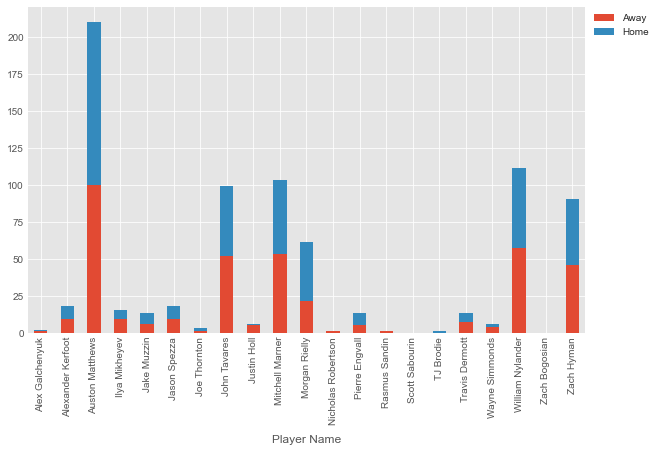

In [82]:
# plot sum of goals per player divided by home or away status
goals_per_player = goal_data.groupby(['full_name', 'home_or_away'])['goals']
ax = goals_per_player.sum().unstack().plot(kind='bar', stacked=True)
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

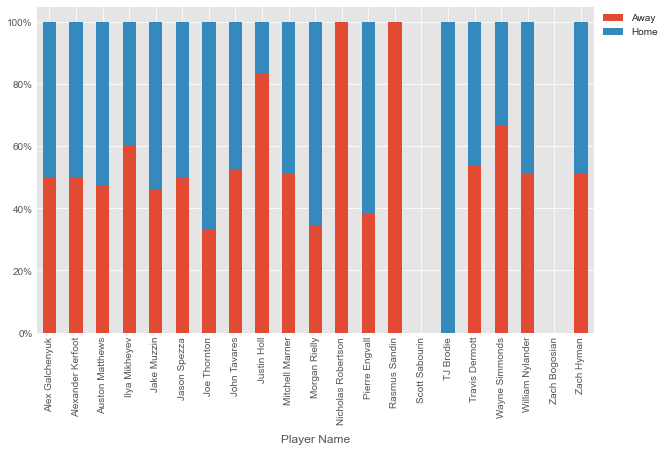

In [85]:
# plot normalized sum of goals per player divided by home or away status
ax = goals_per_player.sum().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar', stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

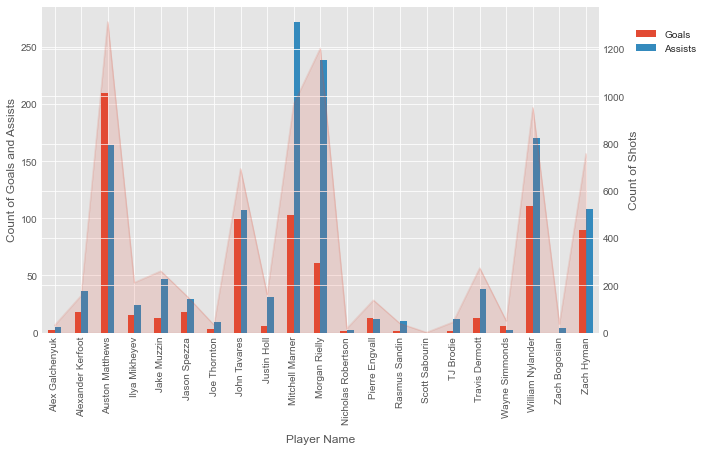

In [83]:
# plot sum of goals per player per opposing team
goals_and_assists_per_player = goal_data.groupby(['full_name'])[['goals', 'assists']]
shots_per_player = goal_data.groupby(['full_name'])['shots']
fig, ax = plt.subplots()
ax1 = ax.twinx()
goals_and_assists_per_player.sum().plot(kind='bar', ax=ax)
ax.set_xlabel('Player Name', labelpad=10)
ax.set_ylabel('Count of Goals and Assists')
ax.legend(['Goals', 'Assists', 'Shots'], loc='lower left', bbox_to_anchor=(1.05, 0.83))
shots_per_player.sum().plot(kind='area', ax=ax1, alpha=0.15)
ax1.set_ylabel('Count of Shots')
plt.show()

### Data Preprocessing
___

In [86]:
# separate data into X and y sets
X = goal_data.loc[:, goal_data.columns != 'goals']
y = goal_data['goals']

In [87]:
# encode categorical features
# all data has been verified and cleaned before so there are no missing or unknown values
categorical_features = ['game_type', 'opposing_team', 'home_or_away', 'full_name', 'primary_position']
categorical_transformer = preprocessing.OneHotEncoder(handle_unknown='ignore')

In [88]:
# normalize numerical features
# all data has been verified and cleaned before so there are no missing or unknown values
numerical_features = ['time_on_ice', 'assists', 'shots', 'hits', 'penalty_minutes',
                      'takeaways', 'giveaways', 'plus_minus']
numerical_transformer = preprocessing.StandardScaler()

In [89]:
# create column transformer that applies both numerical and categorical transformers
preprocessor = compose.ColumnTransformer(
    transformers = [
        ('categorical', categorical_transformer, categorical_features),
        ('numerical', numerical_transformer, numerical_features)
    ]
)

In [90]:
# split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=0
)
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(
    X_test, y_test, test_size=0.6, random_state=0
)

### Elastic-Net Regression
___

### Multi-Layer Perceptron Regression
___

### Results and Analysis
___

### Model Export
___

In [ ]:
# save svm model to disk
pickle.dump(pipeline_en, open('../api/models/regression_pipeline_en.pkl', 'wb'))
# save rf model to disk
pickle.dump(pipeline_mlp, open('../api/models/regression_pipeline_mlp.pkl', 'wb'))